# Comparison measurements and theory

# CURRENT BIG BIG PROBLEMS

Looks good but is probably wrong. I have here removed the A from the simulation plot because i felt like after demodulation it should be gone. Also, i haven't considered the absorption and trasnfer through the photodiode. gotta dig into this.

Reminder of the theory :

$$M_{pump} = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}\frac{\Gamma sin(\omega t) - \Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)} + R_{op} M_0 cos^2(\theta) \frac{\Gamma^2 + \Delta^2}{\Gamma(\Gamma^2+\Delta^2+2\delta^2)}$$

In order to compute the dispersive and absorptive behavior of the medium, we need to extract the susceptibility here.

Taking the AC part of $M_{pump}$, we get:

$$M_{pump,AC} = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}\frac{\Gamma sin(\omega t) - \Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$

One can notice that :
$$\Gamma sin(\omega t) - \Delta cos(\omega t) = \Im{((\Gamma-i\Delta)e^{i \omega t})}$$

We know the general form :
$$M_{AC} = A \Im{(\Chi(\Delta)e^{i \omega t})}$$
By identification :
$$A = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}$$
$$\Chi(\Delta) = \frac{\Gamma - i\Delta}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$

Because of the signal measured is with an MFLI, the DC part plays no role and the $e^{i \omega t}$ is removed to get the X and Y  signals.

Quick notes :

The FWHM seems to fit if and only if the R_op is removed from the $\Gamma_{tot}$, and with a lower field.
It is good to remind that the lorentzian absorptive profile is :
$$\Re{(\Chi)} = \frac{\Gamma_{tot}}{\Gamma_{tot} (\Gamma_{tot}^2 + \Delta^2 + 2\delta^2)} = \frac{1}{\Gamma_{tot}^2 + \Delta^2 + 2\delta^2}$$
Hence, the FWHM is given by:
$$FWHM(\Chi(\Delta)) = 2\sqrt{\Gamma_{tot}^2 + 2\delta^2}$$

Orders of magntiude are weirdly fitting the data if i remove A from the simulation (i assumed it wasn't incorrect because of the demodulation, which offsets the DC, but might be wrong)
additionnally, this didn't take into account the transmission measurement (just the magnetization), so orders of magnitude off. gotta add the A back and properly compute the transmission of light, then the demodulation. 
My current question is regarding how does the real and imaginary part compute in the transmission ?

In [14]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from IPython.display import display, HTML

## Simulation

In [15]:
## constants

sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
g_F = 0.5006
mu_eff = g_F * mu_B  # g_F depends on hyperfine level (±1/2 for Rb-87)
gamma = 7e9             # Gyromagnetic ratio (Hz/T)
Gamma_natural = 36.10e6 # Natural linewidth (Hz)
I_sat = 44.84              # Saturation intensity (W/m²)


## Functions

def R_op(I):
    return Gamma_natural * I / (I + I_sat)

def compute_M_pump(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0):
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0  # Detuning

    numerator_My = Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)
    denominator = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * numerator_My / denominator
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denominator

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz

    # Compute oscillation amplitude
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)

    return M_pump, amplitude, DC_val

In [16]:
## Inputs
T = 273+80                    # Cell temperature (K)
B0 = 163e3/7e9                 # Static magnetic field (T)
B1 = 3.0e-6                # RF magnetic field (T) ESTIMATED IMPRECISELY
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 31.6              # Spin relaxation rate (Hz) ESTIMATED TO FIT THE WIDTH OF THE EXPERIMENTAL CURVES
beam_diameter = 1e-3       # Beam diameter (m)
z_cell = 1.5e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
R = 0.568                  # Photodiode responsivity (A/W)

## Derived Quantities
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6                # Vapor density
M0 = n * mu_eff                  # Max magnetization
omega_0 = gamma * B0              # Larmor frequency (rad/s)
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)  # RF coupling

## Empirical data
I_in = 1e-3           # Laser power [W]
I_out0 = 0.4e-3       # Transmission without RF
T0 = I_out0 / I_in
OD0 = -np.log(T0)


I_laser = I_in / A_beam
R_op = Gamma_natural * I_laser / (I_laser + I_sat)
Gamma_tot = Gamma #+ R_op
delta = (gamma * B1 / (2*np.sqrt(2))) * np.sin(theta)

# AC magnetization prefactor
A = R_op * M0 * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)

# Frequency sweep
#Delta = np.linspace(omega_0-5*Gamma_tot, omega_0+5*Gamma_tot, 30000)
omega = np.linspace(130000, 200000, 1000)
Delta = omega - omega_0

# Complex AC magnetization
chi = (Gamma_tot - 1j*Delta) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))
M_AC =  chi

## The minus sign comes form the fact that the magnetization will orient positively and will translate into more absorption
Y_sim = -np.real(M_AC)  # absorptive (dip)
X_sim = np.imag(M_AC)   # dispersive

OD_mod_real = OD0 * (1 + np.real(M_AC)/M0)
OD_mod = OD0 * (1 + M_AC/M0)

T = I_in * np.exp(-OD_mod)


In [17]:
print('FWHM = ',2*np.sqrt(Gamma_tot**2+2*delta**2))
print('$2\delta^2$', 2*delta**2)

FWHM =  14849.376897365088
$2\delta^2$ 55125000.0


In [18]:
OD0

np.float64(0.916290731874155)

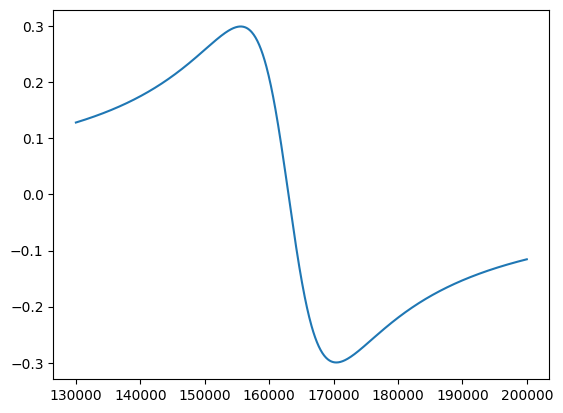

In [19]:
plt.plot(omega, np.imag(M_AC/M0))
plt.show()

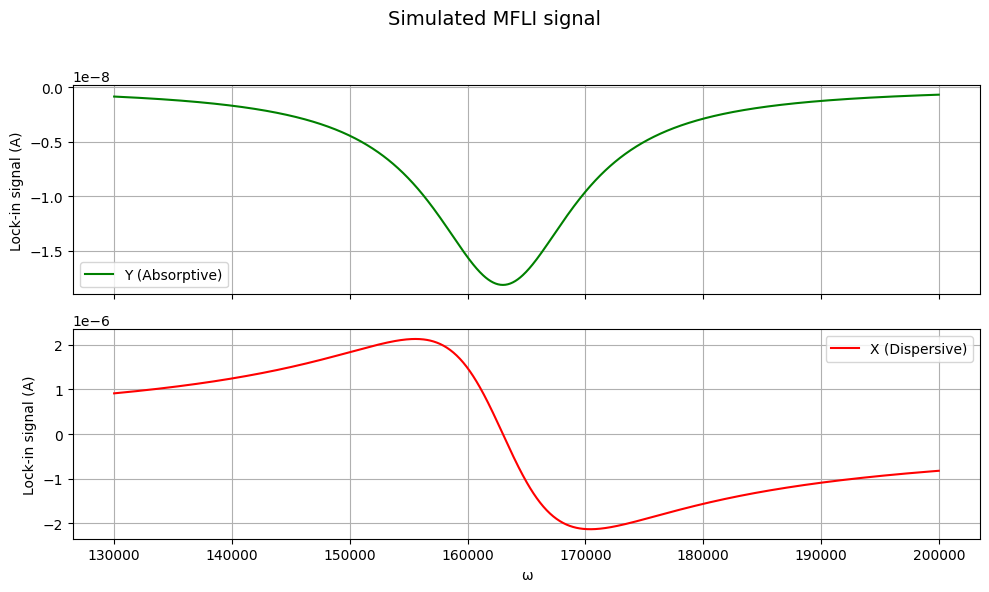

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# --- Top plot: Y_sim ---
ax[0].plot(omega, Y_sim, label='Y (Absorptive)', color='g')
ax[0].set_ylabel("Lock-in signal (A)")
ax[0].grid(True)
ax[0].legend()

# --- Bottom plot: X_sim ---
ax[1].plot(omega, X_sim, label='X (Dispersive)', color='r')
ax[1].set_xlabel("ω")
ax[1].set_ylabel("Lock-in signal (A)")
ax[1].grid(True)
ax[1].legend()

# Single shared title
fig.suptitle("Simulated MFLI signal", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Actual data

Current Data

In [21]:
filename = 'odmr_data/ODMR_serf_130k_200k_X_Y_current_HT.txt'

df = pd.read_csv(filename, 
                   comment='%', 
                   sep=';', 
                   names=['freq', 'X/Y'])

freq = df['freq'][:len(df['freq'])//2]
X = df['X/Y'][:len(df['freq'])//2] 
Y = df['X/Y'][len(df['freq'])//2:] 

freq = np.array(freq)
X = np.array(X)
Y = np.array(Y)

In [22]:
# Basic Lorentzian
def lorentzian(f, A, f0, Gamma):
    return A * (0.5*Gamma)**2 / ((f - f0)**2 + (0.5*Gamma)**2)

# Fit a single Lorentzian in a frequency range
def fit_local_lorentzian(freq, amp, fmin, fmax):
    # select local range
    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]
    
    if len(f_local) == 0:
        return None, None
    
    # Initial guesses
    A0 = np.max(a_local) - np.min(a_local)
    f0_0 = f_local[np.argmax(a_local)]
    G0 = (fmax - fmin) / 10.0
    
    p0 = [A0, f0_0, G0]
    bounds = ([0, fmin, 1e-9], [np.inf, fmax, fmax-fmin])
    
    try:
        popt, pcov = curve_fit(lorentzian, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Fit failed in range", fmin, fmax, ":", e)
        return None, None
    
    return popt, pcov

def inverted_lorentzian(f, A, f0, Gamma, y0):
    """
    A: depth of the dip (positive number)
    f0: center frequency
    Gamma: full width at half maximum (FWHM)
    y0: baseline offset
    """
    return y0 - A * (0.5*Gamma)**2 / ((f - f0)**2 + (0.5*Gamma)**2)

# Fit a single inverted Lorentzian in a frequency range
def fit_local_inverted_lorentzian(freq, amp, fmin, fmax):
    # Convert to numpy arrays if needed
    freq = np.array(freq)
    amp = np.array(amp)

    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]

    if len(f_local) == 0:
        return None, None

    # Initial guesses
    A0 = np.max(a_local) - np.min(a_local)
    f0_0 = f_local[np.argmin(a_local)]
    G0 = (fmax - fmin) / 10.0
    y0_0 = np.max(a_local)

    p0 = [A0, f0_0, G0, y0_0]
    bounds = ([0, fmin, 1e-9, -np.inf], [np.inf, fmax, fmax-fmin, np.inf])

    try:
        popt, pcov = curve_fit(inverted_lorentzian, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Fit failed in range", fmin, fmax, ":", e)
        return None, None

    return popt, pcov

def dispersive(f, A, f0, Gamma, y0):
    d = f - f0
    return y0 + A * (d * (0.5*Gamma)) / (d**2 + (0.5*Gamma)**2)


def fit_local_dispersive(freq, amp, fmin, fmax):
    freq = np.array(freq)
    amp = np.array(amp)

    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]

    if len(f_local) == 0:
        return None, None

    # Initial guesses
    f0_guess = f_local[np.argmin(np.abs(a_local - np.mean(a_local)))]  # zero-crossing approx
    A0 = (np.max(a_local) - np.min(a_local))
    G0 = (fmax - fmin)/10
    y0_0 = np.mean(a_local)

    p0 = [A0, f0_guess, G0, y0_0]
    bounds = ([-np.inf, fmin, 1e-9, -np.inf],
              [ np.inf, fmax, (fmax-fmin),  np.inf])

    try:
        popt, pcov = curve_fit(dispersive, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Dispersive fit failed:", e)
        return None, None

    return popt, pcov


In [23]:
fit_ranges = [
    (freq[0],freq[-1])
]

local_fits = []

for fmin, fmax in fit_ranges:
    popt_L, pcov_L = fit_local_inverted_lorentzian(freq, Y, fmin, fmax)
    if popt_L is not None:
        local_fits.append({
            'fmin': fmin,
            'fmax': fmax,
            'popt_L': popt_L,
            'pcov_L': pcov_L
        })
        
dispersive_fits = []

for fmin, fmax in fit_ranges:   # same fit_ranges as your X fit
    popt_D, pcov_D = fit_local_dispersive(freq, X, fmin, fmax)
    if popt_D is not None:
        dispersive_fits.append({
            'fmin': fmin,
            'fmax': fmax,
            'popt_D': popt_D,
            'pcov_D': pcov_D
        })


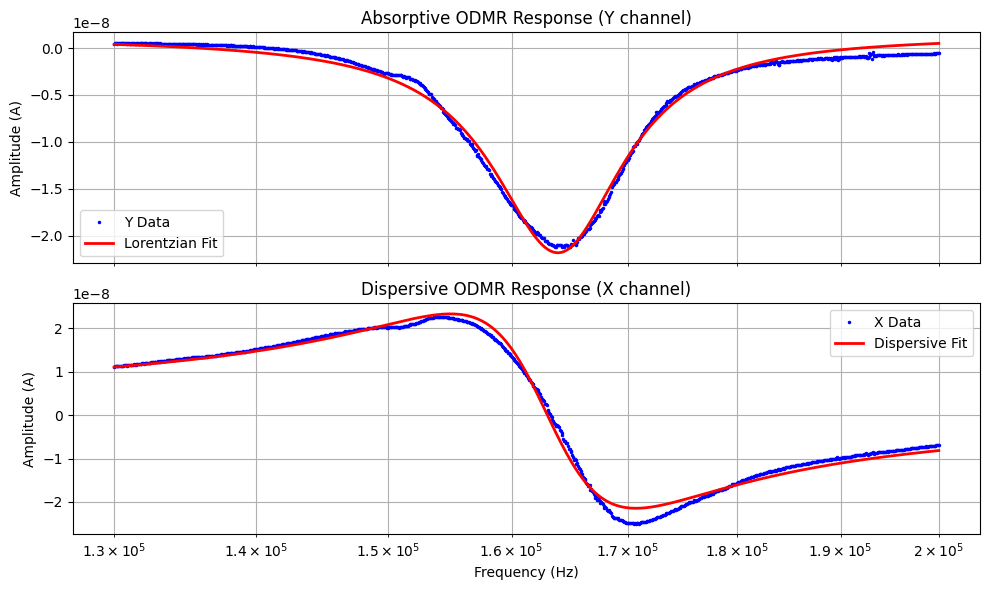


=== FIT RESULTS — Absorptive (X channel) ===
A_L      = 2.309e-08
f0_L     = 163913.967698 Hz
Gamma_L  = 13693.771961 Hz
y0_L     = 0.000000

=== FIT RESULTS — Dispersive (Y channel) ===
A_D      = -4.473e-08
f0_D     = 162854.698345 Hz
Gamma_D  = 15757.852230 Hz
y0_D     = 0.000000


In [24]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(freq, Y, 'b.', markersize=3, label="Y Data")

for fit in local_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_L = fit['popt_L']
    f_fit = np.linspace(fmin, fmax, 300)
    y_fit = inverted_lorentzian(f_fit, *popt_L)
    ax[0].plot(f_fit, y_fit, 'r-', linewidth=2, label="Lorentzian Fit")

ax[0].set_title("Absorptive ODMR Response (Y channel)")
ax[0].set_ylabel("Amplitude (A)")
ax[0].grid(True, which = 'both')
ax[0].legend()

ax[1].plot(freq, X, 'b.', markersize=3, label="X Data")

for fit in dispersive_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_D = fit['popt_D']
    f_plot = np.linspace(fmin, fmax, 300)
    x_fit = dispersive(f_plot, *popt_D)
    ax[1].plot(f_plot, x_fit, 'r-', linewidth=2, label="Dispersive Fit")

ax[1].set_title("Dispersive ODMR Response (X channel)")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude (A)")
ax[1].grid(True, which='both')
ax[1].legend()


plt.xscale('log')   
plt.tight_layout()
plt.show()

A_L, f0_L, Gamma_L, y0_L = popt_L
A_D, f0_D, Gamma_D, y0_D = popt_D

print("\n=== FIT RESULTS — Absorptive (X channel) ===")
print(f"A_L      = {A_L:.4g}")
print(f"f0_L     = {f0_L:.6f} Hz")
print(f"Gamma_L  = {Gamma_L:.6f} Hz")
print(f"y0_L     = {y0_L:.6f}")

print("\n=== FIT RESULTS — Dispersive (Y channel) ===")
print(f"A_D      = {A_D:.4g}")
print(f"f0_D     = {f0_D:.6f} Hz")
print(f"Gamma_D  = {Gamma_D:.6f} Hz")
print(f"y0_D     = {y0_D:.6f}")

## Plot both

In [25]:
## Interpolate simulation onto the experimental frequency axis
X_sim_interp = np.interp(freq, omega, X_sim)
Y_sim_interp = np.interp(freq, omega, Y_sim)


## Restrict simulation to overlap region
mask_sim = (omega >= freq.min()) & (omega <= freq.max())

freq_sim_overlap = omega[mask_sim]
X_sim_overlap    = X_sim[mask_sim]
Y_sim_overlap    = Y_sim[mask_sim]

## Now interpolate simulation onto exp. frequencies
X_sim_interp = np.interp(freq, freq_sim_overlap, X_sim_overlap)
Y_sim_interp = np.interp(freq, freq_sim_overlap, Y_sim_overlap)


## Absorptive fit (inverted Lorentzian)
A_L, f0_L, Gamma_L, y0_L = local_fits[0]['popt_L']
X_fit = inverted_lorentzian(freq, A_L, f0_L, Gamma_L, y0_L)

## Dispersive fit
A_D, f0_D, Gamma_D, y0_D = dispersive_fits[0]['popt_D']
Y_fit = dispersive(freq, A_D, f0_D, Gamma_D, y0_D)


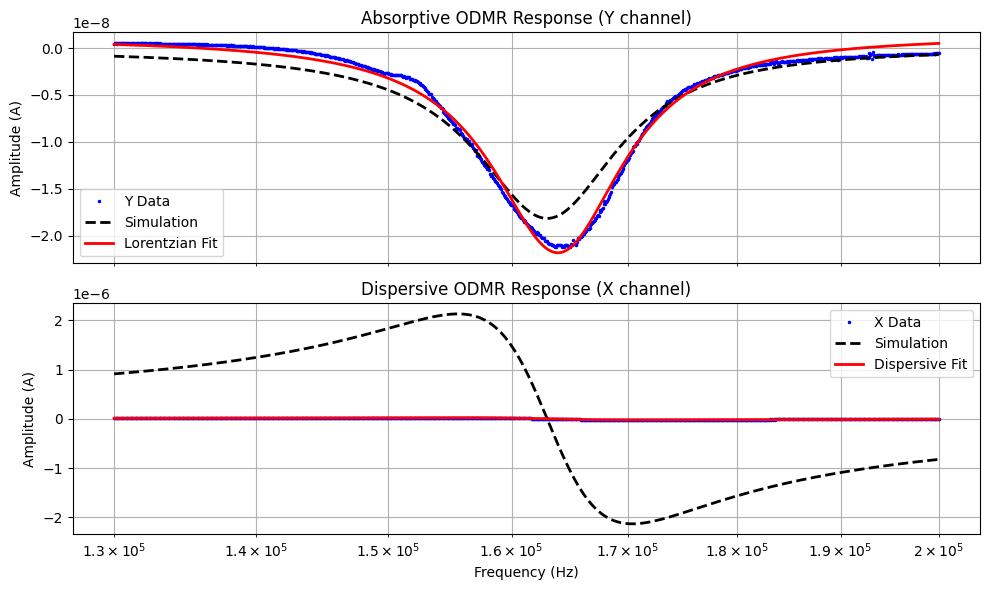

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(freq, Y, 'b.', markersize=3, label="Y Data")
ax[0].plot(freq, Y_sim_interp, 'k--', linewidth=2, label="Simulation")

for fit in local_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_L = fit['popt_L']
    f_fit = np.linspace(fmin, fmax, 300)
    y_fit = inverted_lorentzian(f_fit, *popt_L)
    ax[0].plot(f_fit, y_fit, 'r-', linewidth=2, label="Lorentzian Fit")

ax[0].set_title("Absorptive ODMR Response (Y channel)")
ax[0].set_ylabel("Amplitude (A)")
ax[0].grid(True, which = 'both')
ax[0].legend()

ax[1].plot(freq, X, 'b.', markersize=3, label="X Data")
ax[1].plot(freq, X_sim_interp, 'k--', linewidth=2, label="Simulation")



for fit in dispersive_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_D = fit['popt_D']
    f_plot = np.linspace(fmin, fmax, 300)
    x_fit = dispersive(f_plot, *popt_D)
    ax[1].plot(f_plot, x_fit, 'r-', linewidth=2, label="Dispersive Fit")

ax[1].set_title("Dispersive ODMR Response (X channel)")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude (A)")
ax[1].grid(True, which='both')
ax[1].legend()


plt.xscale('log')   
plt.tight_layout()
plt.show()